In [1]:
import numpy as np
import os
from keras.models import Model
from keras import layers

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
def _parse_function(proto):

    keys_to_features = {'sound': tf.FixedLenFeature([], tf.string),
                        "label": tf.FixedLenFeature([], tf.float32)}
    
    # Load one example
    parsed_features = tf.parse_single_example(proto, keys_to_features)
    
    # Turn the sound string back into an array
    parsed_features['sound'] = tf.decode_raw(parsed_features['sound'], tf.float32)
    
    
    return parsed_features['sound'], parsed_features["label"]

In [4]:
def create_dataset(filepath, classification=True):
    
    files = [filepath + "/" + file for file in os.listdir(filepath)]

    dataset = tf.data.TFRecordDataset(files)
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=4)
    
    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(buffer_size=2024)


    # This dataset will go on forever
    dataset = dataset.repeat()
        
    # Set the batchsize
    dataset = dataset.batch(batchsize)
    
    # Create an iterator
    iterator = dataset.make_one_shot_iterator()
    
    # Create your tf representation of the iterator
    sound, label = iterator.get_next()

    # reshape
    sound = tf.reshape(sound, [-1, 24000, 1])
    label = tf.reshape(label, [-1, 1])
        
    return sound, label

In [7]:
train_filepath = "./data/tf_data/train"
validation_filepath = "./data/tf_data/validation"

test_filepath = "./data/tf_data/test"
batchsize =55
epochs = 25
train_samples = sum([int(file.split("_")[0]) for file in os.listdir(train_filepath)])
test_samples = sum([int(file.split("_")[0]) for file in os.listdir(test_filepath)])

print("test samples=",test_samples)

train_samples

test samples= 8008


26007

In [8]:
val_samples = sum([int(file.split("_")[0]) for file in os.listdir(validation_filepath)])
val_samples

5990

In [16]:
sound, label = create_dataset(train_filepath)
sound.shape

TensorShape([Dimension(None), Dimension(24000), Dimension(1)])

In [17]:
val_sound, val_label = create_dataset(validation_filepath)

# Model

In [18]:
# inputs = layers.Input(shape=(data.shape[1],1))
inputs = layers.Input(tensor=sound)

conv1 = layers.Conv1D(filters=64, kernel_size=129, padding="same")(inputs)
pool1 = layers.MaxPool1D(8)(conv1)

reshape = layers.Reshape((3000,64,1))(pool1)

conv2 = layers.Conv2D(filters=96, kernel_size=(61,1), padding="same", activation='relu')(reshape)
#conv2 = layers.Conv2D(filters=10, kernel_size=(61,64), padding="same", activation='relu')(reshape)

pool2 = layers.MaxPool2D((8,1))(conv2)
conv3 = layers.Conv2D(filters=128, kernel_size=(35,1), padding="same", activation='relu')(pool2)
pool3 = layers.MaxPool2D((4,1))(conv3)
conv4 = layers.Conv2D(filters=160, kernel_size=(17,1), padding="same", activation='relu')(pool3)
pool4 = layers.MaxPool2D((12,1))(conv4)
avgpool = layers.AveragePooling2D((5,1))(pool4)

flatten = layers.Flatten()(avgpool)

dense1 = layers.MaxoutDense(output_dim=128,nb_feature=4)(flatten)
dropout1 = layers.Dropout(0.5)(dense1)
dense2 = layers.MaxoutDense(output_dim=64, nb_feature=4)(dropout1)
dropout2 = layers.Dropout(0.5)(dense2)

# max_out = maximum([Dense(neurons, **dense_args)(input_layer) for _ in range(n_pieces)])

output = layers.Dense(1, activation="sigmoid")(dropout2)

In [19]:
model = Model(inputs=inputs, outputs=output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 24000, 1)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24000, 64)         8320      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3000, 64)          0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 3000, 64, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3000, 64, 96)      5952      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 375, 64, 96)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 375, 64, 128)      430208    
__________

In [20]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
              target_tensors=[label])

In [21]:
history = model.fit(epochs=epochs,
                    steps_per_epoch=int(train_samples/batchsize),
                    validation_data=(val_sound, val_label),
                    validation_steps=int(val_samples/batchsize))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/25
472/472 [==============================] - 555s 1s/step - loss: 0.6833 - acc: 0.5678 - val_loss: 0.6842 - val_acc: 0.5744
Epoch 2/25
472/472 [==============================] - 543s 1s/step - loss: 0.6329 - acc: 0.6414 - val_loss: 0.6087 - val_acc: 0.6774
Epoch 3/25
472/472 [==============================] - 545s 1s/step - loss: 0.5785 - acc: 0.7041 - val_loss: 0.6094 - val_acc: 0.6744
Epoch 4/25
472/472 [==============================] - 545s 1s/step - loss: 0.5544 - acc: 0.7236 - val_loss: 0.5776 - val_acc: 0.6975
Epoch 5/25
472/472 [==============================] - 545s 1s/step - loss: 0.5392 - acc: 0.7333 - val_loss: 0.5165 - val_acc: 0.7456
Epoch 6/25
472/472 [==============================] - 545s 1s/step - loss: 0.5176 - acc: 0.7502 - val_loss: 0.5037 - val_acc: 0.7652
Epoch 7/25
472/472 [==============================] - 549s 1s/step - loss: 0

In [22]:
history_old = history

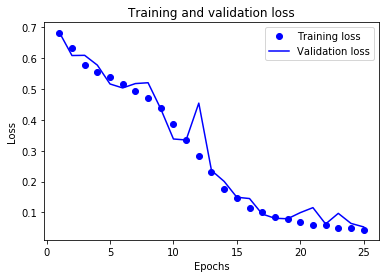

In [24]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

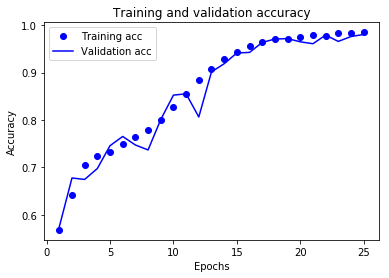

In [25]:
history_dict = history.history
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
#################  WARNING ############################
################# SAVE THE TRAINED MODEL
model.save('./trained_models/model_paper/model.h5')


In [27]:
test_filepath = "./data/tf_data/test"
test_sound, test_label = create_dataset(test_filepath)

In [36]:
ynew = model.predict(test_sound,batch_size=batchsize)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [31]:
test_sound.shape

TensorShape([Dimension(None), Dimension(24000), Dimension(1)])